<a href="https://colab.research.google.com/github/vifirsanova/ml-course/blob/main/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Матрицы в механизме внимания**

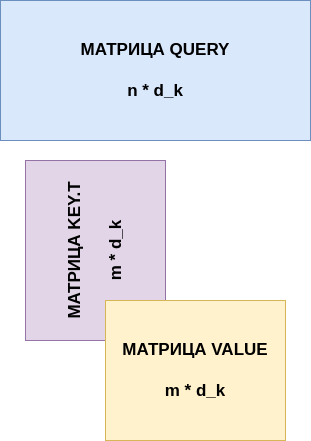

**МАТРИЦА QUERY $Q$**

- Задает входные данные
- Размерность матрицы: $(n, d_k)$, где
  - $n$ - длина входной последовательности
  - $d_k$ - ширина матрицы, задается как гиперпараметр и совпадает с шириной матриц $K$ и $V$ (это важно для матричных вычислений), например, в ванильном трансформере это значение задается так:
    - $d_k = \frac{d_{\text{model}}}{h}$, где
      - $d_{\text{model}}$ - размер входной последовательностей на слое эмбеддингов, например, 512 (ср. максимальная длина входной последовательности в модели BERT)
      - $h$ - количество голов внимания, например, 8
      - так, $d_k$ равно $512/8 = 64$

**МАТРИЦЫ KEY $K$ И VALUE $V$**

- Задают выходные данные, т.е. выходные последовательности задаются как пары "ключ-значение"
- Интуитивно, использование 2х матриц подражает поиску значения слова в словаре
  - Например, мы ищем перевод для слова "pug", находим в словаре ключ "мопс" и его значение "порода собак с плоской мордой"
  - Более конкретно: ключ задает слово, а значение - вычисляемый механизмом внимания контекст (~эмбеддинг)
  - Фактически: мы используем 2 одинаковые матрицы для вычисления весов внимания   
- Для матричного произведения одну матрицу необходимо транспонировать, чтобы количество столбцов в первой матрице совпадало с количетсвом строк во второй: $K^T$

### **Иллюстрация раборы Cross-Attention**

**Cross-attention** (перекрестное внимание) связывает 2 разных объекта, например:

- Исходный текст X и его саммари Y
- Текст на исходном языке X и его перевод на целевой язык Y
- Описание изображения на естественном языке X и само изображение Y

Модель обрабатывает три матрицы: $Q$, $K$, $V$

Значения этих матриц параметризуются методом обратного распространения ошибки: $QW^Q_i$, $KW^K_i$, $VW^V_i$, где

- $W$ - веса, обучаемые параметры
- $i$ - текущая голова модели (если $Multihead$)

Если это внутреннее внимание, то на входе $Q = K = V$, которые выводятся из входной последовательности $X$

Если это перекрестное внимание, то матрица $Q$ выводится из входной последовательности $X$, а матрицы $K$, $V$ - из $Y$

**Масштабирование**

Деление на `√d_k` (масштабирование)

$\text{scores} = \frac{QK^T}{\sqrt{d_k}}$

Зачем это нужно?

- Стабилизация градиентов:  
   - Если значение `d_k` большое, то скалярное произведение может принимать очень большие значения
   - Значения увеличиваются в результате применения softmax (почти one-hot encoding)
   - Масштабирование сохраняет градиенты в разумном диапазоне
   - Если `Q` и `K` — случайные векторы с дисперсией 1, то дисперсия их скалярного произведения равна `d_k`
   - Деление на `√d_k` делает дисперсию ~1

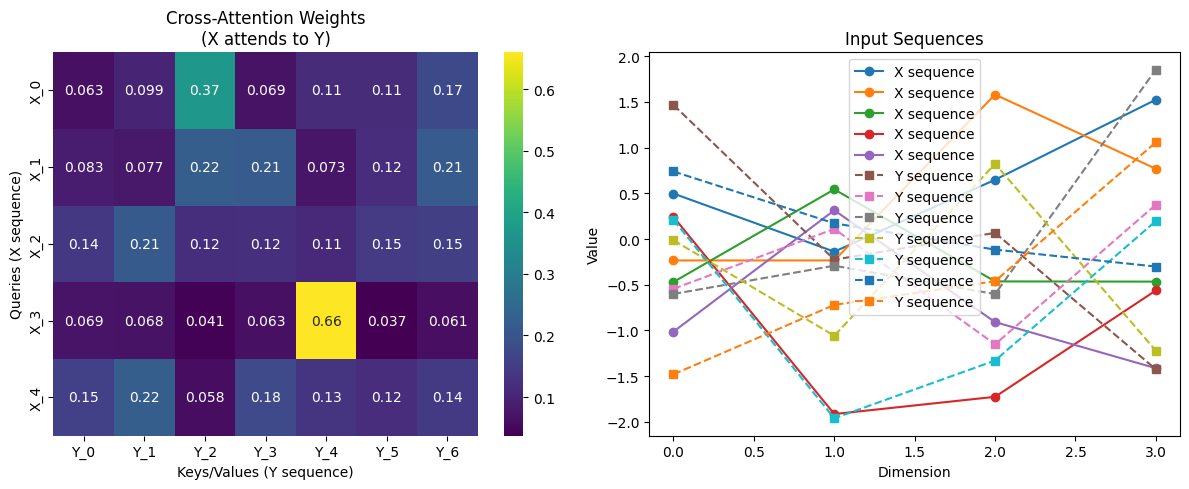

Attention output shape: (5, 4)
Attention weights shape: (5, 7)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def cross_attention(X, Y):
    """
    Низкоуровневая имплементация механизма cross-attention для двух последовательностей X и Y.

    Args:
        X: Входная последовательность размерности (n, d_k), Query
        Y: Выходная последовательности размерности (m, d_k), Key/Value

    Returns:
        attention_output: мэппинг внимания (n, d_k)
        attention_weights: выходная матрица внимания размерности (n, m)
    """
    # 1. Вычисляем матрицы query, key, value
    Q = X  # (n, d_k)
    K = Y  # (m, d_k)
    V = Y  # (m, d_k)

    # Вычисляем скоры внимания
    d_k = Q.shape[-1] # Размерность матрицы запросов Q, т.е. d_k
    # Вычисляет скалярное произведение между всеми векторами запросов Q и ключей K
    # K.T — транспонированная матрица ключей (чтобы размерности совпали)
    scores = np.dot(Q, K.T) / np.sqrt(d_k)  # (n, m)
    # Мы применили масштабирование к скалярному произведению,
    # чтобы избежать слишком больших или малых значений после softmax

    # Вычисляем веса внимания (вариант softmax)
    # 1. np.max(scores, axis=-1, keepdims=True)
    #    Находит максимальное значение в каждой строке матрицы scores (т.е. для каждого запроса)
    #    axis=-1 — операция применяется по последней оси (по столбцам для 2D-матрицы)
    #    keepdims=True — сохраняет исходную размерность (например, (n, 1) вместо (n,))
    # 2. scores - np.max(...)
    #    Вычитает максимум из каждого элемента строки
    #    Теперь все значения ≤ 0, а максимальное значение в строке = 0
    #    Сдвиг не меняет итоговые вероятности softmax, но предотвращает слишком большие значения в exp
    # 3. np.exp(...)
    #    Применяет экспоненту к каждому элементу, так что все значения теперь в диапазоне (0, 1]
    #    Чем больше исходный score, тем ближе результат к 1
    attention_weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    # 4. np.sum(..., axis=-1, keepdims=True)
    #    Суммирует значения в каждой строке (для нормализации)
    #        axis=-1 — суммирование по столбцам
    #        keepdims=True — сохраняет размерность (n, 1)
    # 5. Деление attention_weights / np.sum(...)
    #    Нормализует значения в каждой строке так, чтобы их сумма = 1
    #    Это и есть итоговые вероятности внимания
    attention_weights = attention_weights / np.sum(attention_weights, axis=-1, keepdims=True)

    # Вычисляем взвешенную сумму весов: умножаем вероятности внимания на матрицу V
    attention_output = np.dot(attention_weights, V)  # (n, d_k)

    return attention_output, attention_weights

# Генерируем 2 случайные последовательности для визуализации
np.random.seed(42)
X = np.random.randn(5, 4)  # 5 токенов, 4 изменения
Y = np.random.randn(7, 4)  # 7 токенов, 4 изменения

# Вычисляем cross-attention
output, weights = cross_attention(X, Y)

# Визуализируем
plt.figure(figsize=(12, 5))

# Матрица внимания
plt.subplot(1, 2, 1)
sns.heatmap(weights, cmap="viridis", annot=True,
            xticklabels=[f"Y_{i}" for i in range(len(Y))],
            yticklabels=[f"X_{i}" for i in range(len(X))])
plt.title("Cross-Attention Weights\n(X attends to Y)")
plt.xlabel("Keys/Values (Y sequence)")
plt.ylabel("Queries (X sequence)")

# Визуализация последовательностей чисел
plt.subplot(1, 2, 2)
plt.plot(X.T, 'o-', label='X sequence')
plt.plot(Y.T, 's--', label='Y sequence')
plt.title("Input Sequences")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

print("Attention output shape:", output.shape)
print("Attention weights shape:", weights.shape)

### **Self-Attention**

Отличия внутреннего внимания:

- $Q$, $K$, $V$ выводятся из $X$
- Результирующая матрица квадратная
- Диагональный паттерн, отражает силу связи между токенами внутри одной последовательности

Co-reference resolution

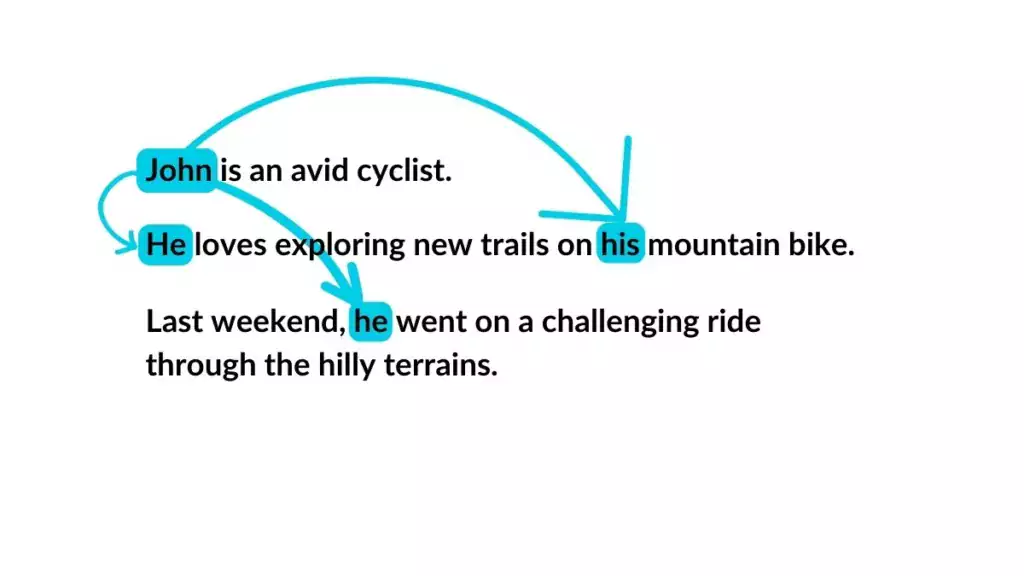

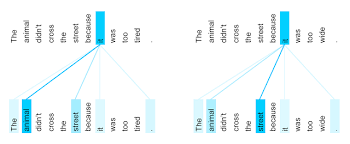

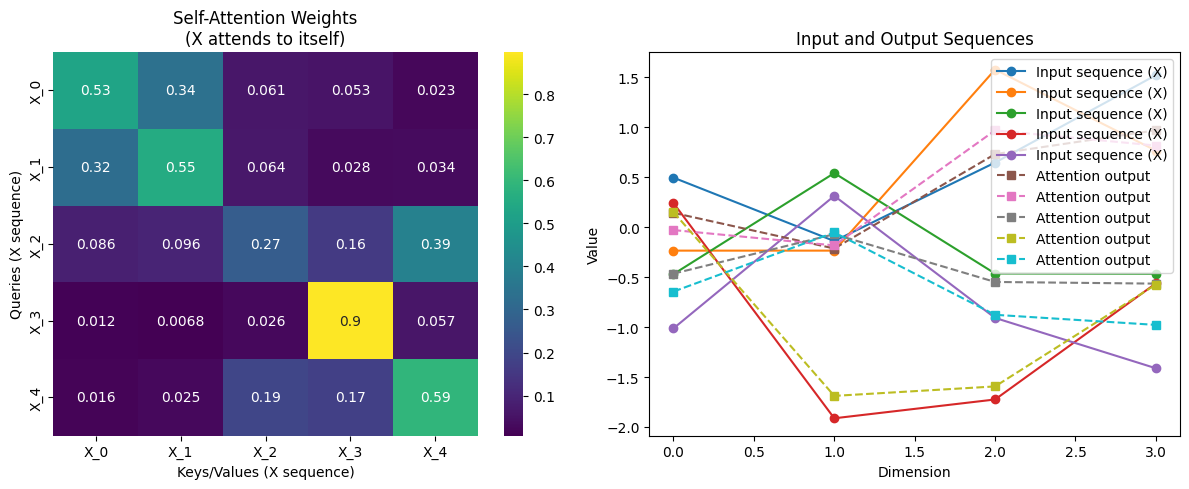

Attention output shape: (5, 4)
Attention weights shape: (5, 5)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def self_attention(X):
    """
    Низкоуровневая реализация внутреннего внимания

    Args:
        X: Входная последовательность (n, d_k)

    Returns:
        attention_output: (n, d_k)
        attention_weights: (n, n)
    """
    # Значения "параметризуются" и выводятся из входных последовательностей
    Q = X  # (n, d_k)
    K = X  # (n, d_k)
    V = X  # (n, d_k)

    # Вычисляем веса внимания
    d_k = Q.shape[-1]
    scores = np.dot(Q, K.T) / np.sqrt(d_k)  # (n, n)

    attention_weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    attention_weights = attention_weights / np.sum(attention_weights, axis=-1, keepdims=True)

    # Взвешенная сумма
    attention_output = np.dot(attention_weights, V)  # (n, d_k)

    return attention_output, attention_weights

# Генерация последовательности
np.random.seed(42)
X = np.random.randn(5, 4)  # 5 токенов, 4 измерения

# Вычисляем self-attention
output, weights = self_attention(X)

# Визуализируем
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(weights, cmap="viridis", annot=True,
            xticklabels=[f"X_{i}" for i in range(len(X))],
            yticklabels=[f"X_{i}" for i in range(len(X))])
plt.title("Self-Attention Weights\n(X attends to itself)")
plt.xlabel("Keys/Values (X sequence)")
plt.ylabel("Queries (X sequence)")

plt.subplot(1, 2, 2)
plt.plot(X.T, 'o-', label='Input sequence (X)')
plt.plot(output.T, 's--', label='Attention output')
plt.title("Input and Output Sequences")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

print("Attention output shape:", output.shape)
print("Attention weights shape:", weights.shape)

### **Многоголовое внимание**

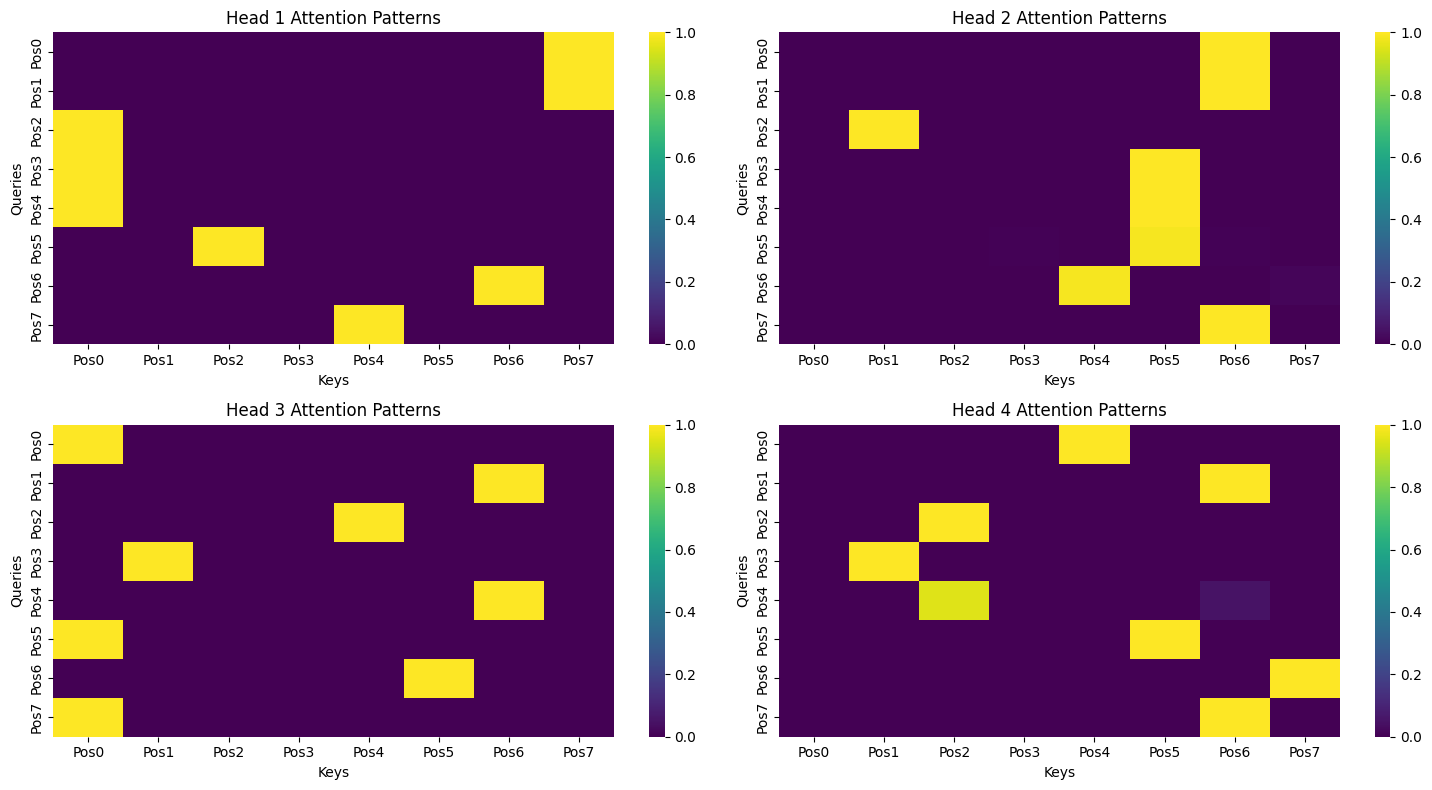

Input shape: (1, 8, 64)
Output shape: (1, 8, 64)
Attention weights shape: (1, 4, 8, 8)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def split_heads(x, num_heads):
    batch_size, seq_len, d_model = x.shape
    depth = d_model // num_heads
    return x.reshape(batch_size, seq_len, num_heads, depth).transpose(0, 2, 1, 3)

def combine_heads(x):
    batch_size, num_heads, seq_len, depth = x.shape
    return x.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, num_heads * depth)

def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.shape[-1]
    scores = np.matmul(q, k.swapaxes(-2, -1)) / np.sqrt(d_k)

    if mask is not None:
        scores = scores + (mask * -1e9)

    attention_weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    attention_weights = attention_weights / np.sum(attention_weights, axis=-1, keepdims=True)

    output = np.matmul(attention_weights, v)
    return output, attention_weights

class MultiHeadAttention:
    def __init__(self, d_model=64, num_heads=4):
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = np.random.randn(d_model, d_model)
        self.wk = np.random.randn(d_model, d_model)
        self.wv = np.random.randn(d_model, d_model)
        self.wo = np.random.randn(d_model, d_model)

    def __call__(self, x, mask=None):
        batch_size, seq_len, _ = x.shape

        # Линейные преобразования
        q = np.matmul(x, self.wq)  # (batch_size, seq_len, d_model)
        k = np.matmul(x, self.wk)  # (batch_size, seq_len, d_model)
        v = np.matmul(x, self.wv)  # (batch_size, seq_len, d_model)

        # Головы
        q = split_heads(q, self.num_heads)  # (batch_size, num_heads, seq_len, depth)
        k = split_heads(k, self.num_heads)
        v = split_heads(v, self.num_heads)

        # Scaled dot-product attention для каждой головы
        attention_outputs = []
        attention_weights = []
        for head in range(self.num_heads):
            out, weights = scaled_dot_product_attention(
                q[:, head, :, :],
                k[:, head, :, :],
                v[:, head, :, :],
                mask
            )
            attention_outputs.append(out)
            attention_weights.append(weights)

        # Объединение результатов вычислений с каждой голосы
        attention_output = np.stack(attention_outputs, axis=1)  # (batch_size, num_heads, seq_len, depth)
        attention_output = combine_heads(attention_output)  # (batch_size, seq_len, d_model)

        # Вывод
        output = np.matmul(attention_output, self.wo)
        attention_weights = np.stack(attention_weights, axis=1)  # (batch_size, num_heads, seq_len, seq_len)

        return output, attention_weights

np.random.seed(42)
batch_size = 1
seq_len = 8
d_model = 64
x = np.random.randn(batch_size, seq_len, d_model)

num_heads = 4
mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

output, all_attention_weights = mha(x)

plt.figure(figsize=(15, 8))

for head in range(num_heads):
    plt.subplot(2, 2, head+1)
    sns.heatmap(all_attention_weights[0, head], cmap="viridis", annot=False,
                xticklabels=[f"Pos{i}" for i in range(seq_len)],
                yticklabels=[f"Pos{i}" for i in range(seq_len)])
    plt.title(f"Head {head+1} Attention Patterns")
    plt.xlabel("Keys")
    plt.ylabel("Queries")

plt.tight_layout()
plt.show()

print("Input shape:", x.shape)
print("Output shape:", output.shape)
print("Attention weights shape:", all_attention_weights.shape)

**Визуализация**

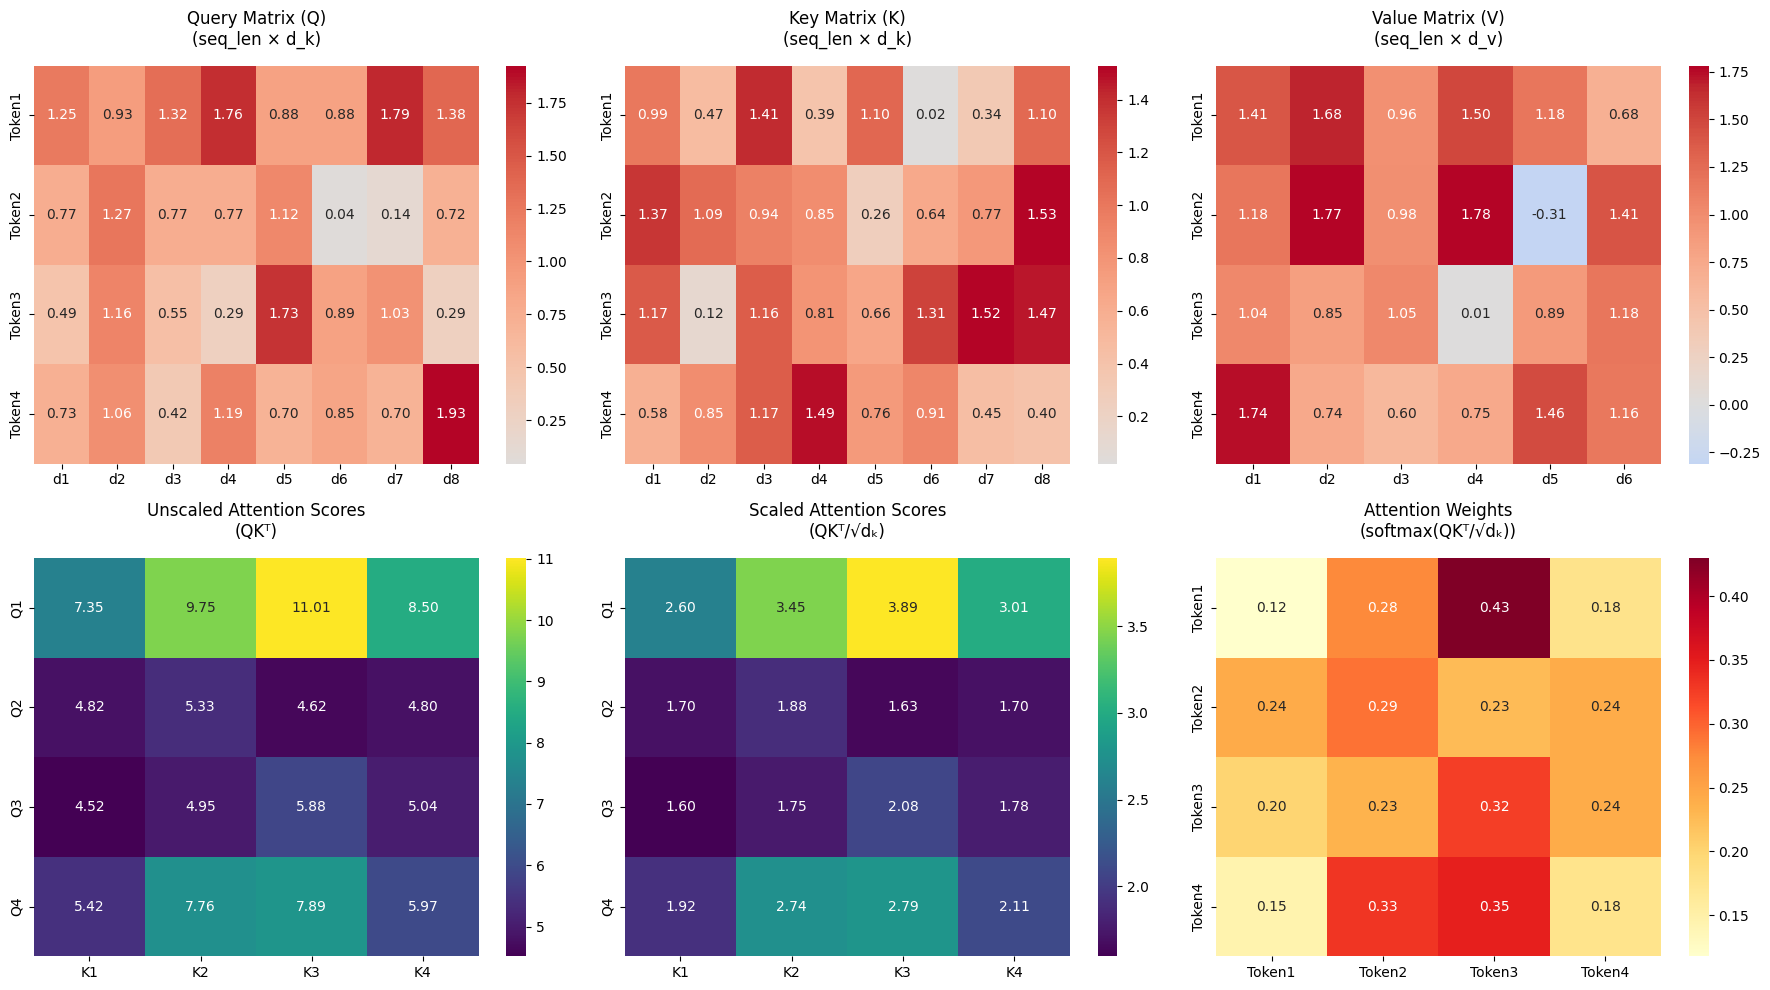

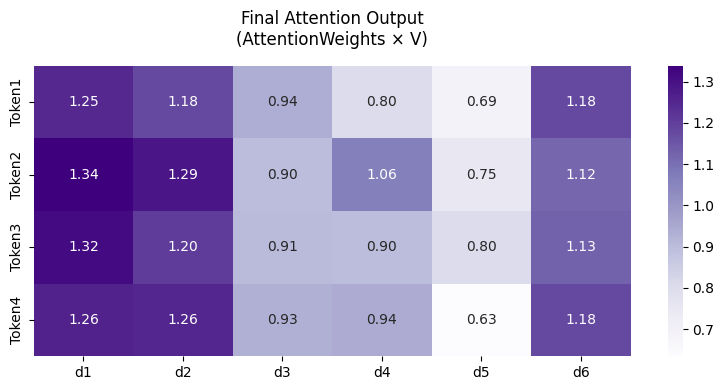

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_scaled_dot_product_attention():
    np.random.seed(42)

    seq_len = 4
    d_k = 8
    d_v = 6

    Q = np.random.randn(seq_len, d_k) * 0.5 + 1  # Queries (seq_len, d_k)
    K = np.random.randn(seq_len, d_k) * 0.5 + 1  # Keys (seq_len, d_k)
    V = np.random.randn(seq_len, d_v) * 0.5 + 1  # Values (seq_len, d_v)

    plt.figure(figsize=(18, 10))

    # 1. Исходные матрицы
    plt.subplot(2, 3, 1)
    sns.heatmap(Q, cmap="coolwarm", center=0, annot=True, fmt=".2f",
                xticklabels=[f"d{i+1}" for i in range(d_k)],
                yticklabels=[f"Token{i+1}" for i in range(seq_len)])
    plt.title("Query Matrix (Q)\n(seq_len × d_k)", pad=15)

    plt.subplot(2, 3, 2)
    sns.heatmap(K, cmap="coolwarm", center=0, annot=True, fmt=".2f",
                xticklabels=[f"d{i+1}" for i in range(d_k)],
                yticklabels=[f"Token{i+1}" for i in range(seq_len)])
    plt.title("Key Matrix (K)\n(seq_len × d_k)", pad=15)

    plt.subplot(2, 3, 3)
    sns.heatmap(V, cmap="coolwarm", center=0, annot=True, fmt=".2f",
                xticklabels=[f"d{i+1}" for i in range(d_v)],
                yticklabels=[f"Token{i+1}" for i in range(seq_len)])
    plt.title("Value Matrix (V)\n(seq_len × d_v)", pad=15)

    # 2. Вычисление скоров внимания (QK^T)
    scores = np.dot(Q, K.T)

    plt.subplot(2, 3, 4)
    sns.heatmap(scores, cmap="viridis", annot=True, fmt=".2f",
                xticklabels=[f"K{i+1}" for i in range(seq_len)],
                yticklabels=[f"Q{i+1}" for i in range(seq_len)])
    plt.title("Unscaled Attention Scores\n(QKᵀ)", pad=15)

    # 3. Масштабирование (scaling)
    scaled_scores = scores / np.sqrt(d_k)

    plt.subplot(2, 3, 5)
    sns.heatmap(scaled_scores, cmap="viridis", annot=True, fmt=".2f",
                xticklabels=[f"K{i+1}" for i in range(seq_len)],
                yticklabels=[f"Q{i+1}" for i in range(seq_len)])
    plt.title("Scaled Attention Scores\n(QKᵀ/√dₖ)", pad=15)

    # 4. Softmax, веса внимания
    attention_weights = np.exp(scaled_scores - np.max(scaled_scores, axis=-1, keepdims=True))
    attention_weights = attention_weights / np.sum(attention_weights, axis=-1, keepdims=True)

    plt.subplot(2, 3, 6)
    sns.heatmap(attention_weights, cmap="YlOrRd", annot=True, fmt=".2f",
                xticklabels=[f"Token{i+1}" for i in range(seq_len)],
                yticklabels=[f"Token{i+1}" for i in range(seq_len)])
    plt.title("Attention Weights\n(softmax(QKᵀ/√dₖ))", pad=15)

    plt.tight_layout()
    plt.show()

    attention_output = np.dot(attention_weights, V)

    plt.figure(figsize=(8, 4))
    sns.heatmap(attention_output, cmap="Purples", annot=True, fmt=".2f",
                xticklabels=[f"d{i+1}" for i in range(d_v)],
                yticklabels=[f"Token{i+1}" for i in range(seq_len)])
    plt.title("Final Attention Output\n(AttentionWeights × V)", pad=15)
    plt.tight_layout()
    plt.show()

visualize_scaled_dot_product_attention()